In [2]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from formulaic import Formula

In [3]:
# Si necesitan instalar algún paquete
#!pip install gapminder
#!pip install formulaic

In [4]:
# Si necesitan cambiar de directorio de trabajo
#import os
#print(pwd)
#os.chdir('./notebooks')

Retomamos la última parte del notebook de la clase anterior

# Interacciones entre variables y la paradoja de Simpson.

Queremos estudiar la relación entre la longitud y la profundidad del pico de los pingüinos.

In [5]:
penguins = sns.load_dataset("penguins")  # Eliminamos las filas con datos faltantes
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [6]:
# Vemos que hay datos faltanes.
# Eliminamos las filas con datos faltantes
penguins = penguins.dropna()  
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [7]:
# Ajustamos un modelo lineal y calculamos el coeficiente de correlación R^2
y, X = (
    Formula('bill_length_mm ~ bill_depth_mm')
    .get_model_matrix(penguins)
)
display(X.head()) 

,Intercept,bill_depth_mm
0,1.0,18.7
1,1.0,17.4
2,1.0,18.0
4,1.0,19.3
5,1.0,20.6


In [8]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realizamos el ajuste
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[54.89085425 -0.63490517]]
R^2:  0.05226968139663679
Raiz cuadarada del ECM:  5.315827723866953


Si analizamos rápidamente estos resultados diríamos que no hay relación entre el largo y la produndidad... (o que hay correlación negativa porque la pendiente es negativa). Resulta un poco extraño...

¿Cómo podemos analizar mejor qué está pasando?

Realicemos un gráfico!

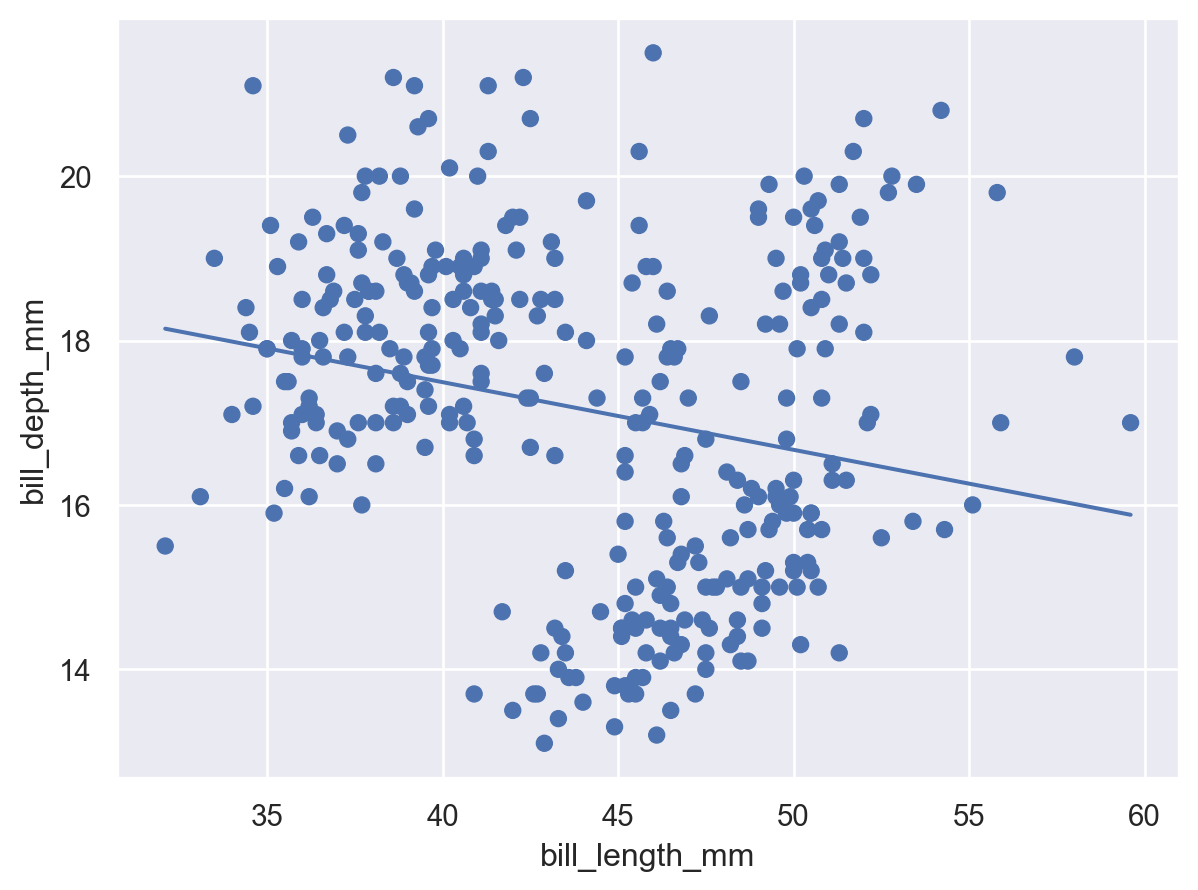

In [9]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

El gráfico confirma la correlación negativa, pero notan algo raro? Tal vez hay algo que no estamos teniendo en cuenta?




Repetimos el gráfico coloreando los puntos según la especie.

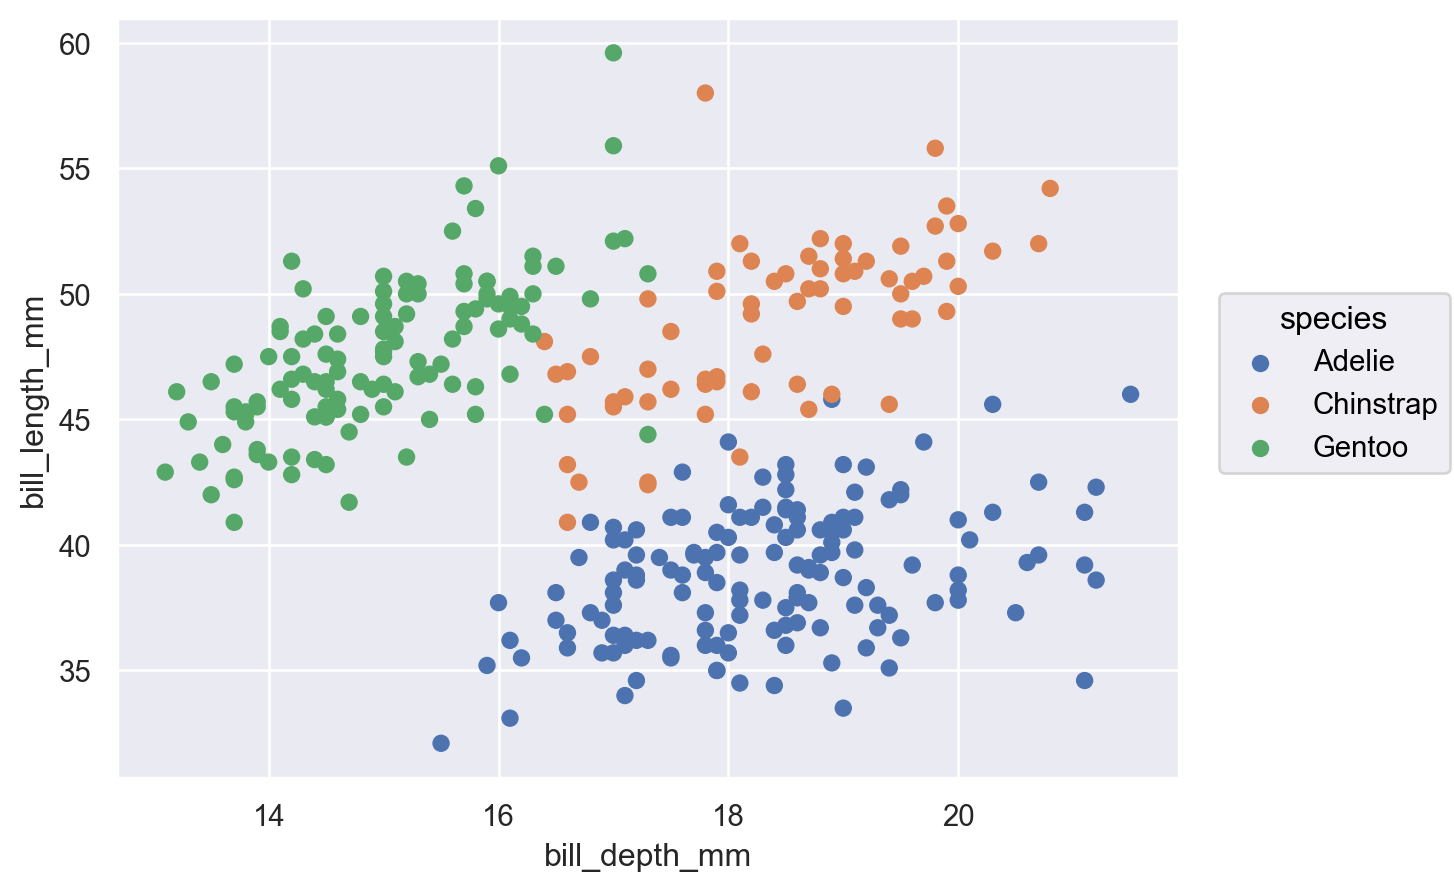

In [10]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
)

En este gráfico por especie vemos dentro de cada especie puede haber correlación. Verificamos agregando los ajustes por especie.

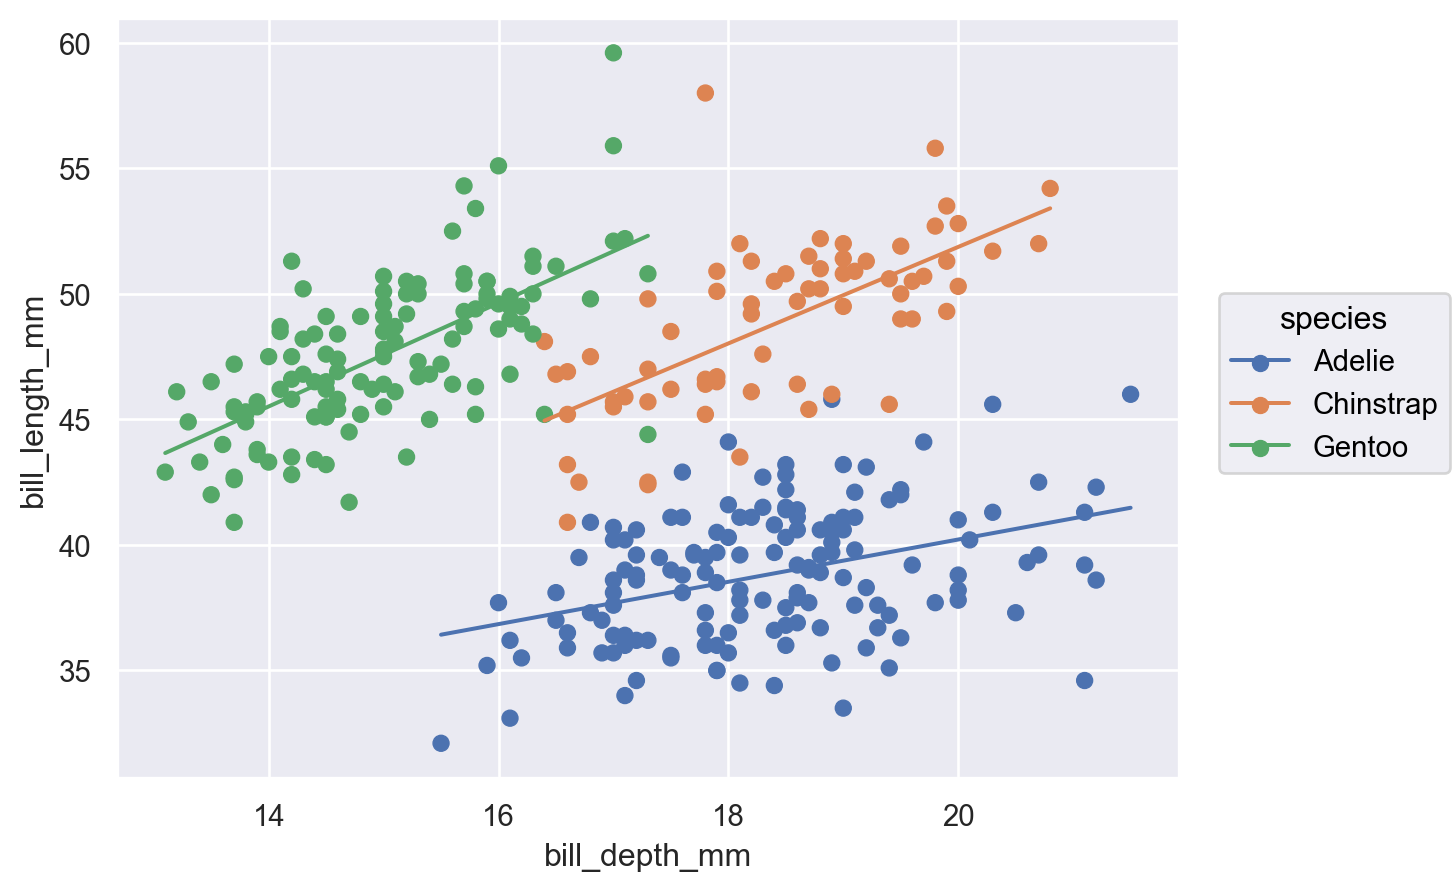

In [11]:
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

Ahora las rectas tienen pendiente positiva! Al considerar todas las especies al mismo tiempo, no podíamos ver esta correlación.

## La paradoja de Simpson
La paradoja de Simpson es un fenómeno estadístico en el cual una relación entre variables aparece, desaparece o se revierte al dividir a la población en subpoblaciones.

**Ejemplo.** Veamos otro ejemplo simulado.
Generamos dos poblaciones distribuidas aleatoriamente alrededor de dos centros.

In [12]:
from sklearn.datasets import make_blobs
centers = [[2, 2], [-2, -2]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
x = X[:,0]
y = X[:,1]

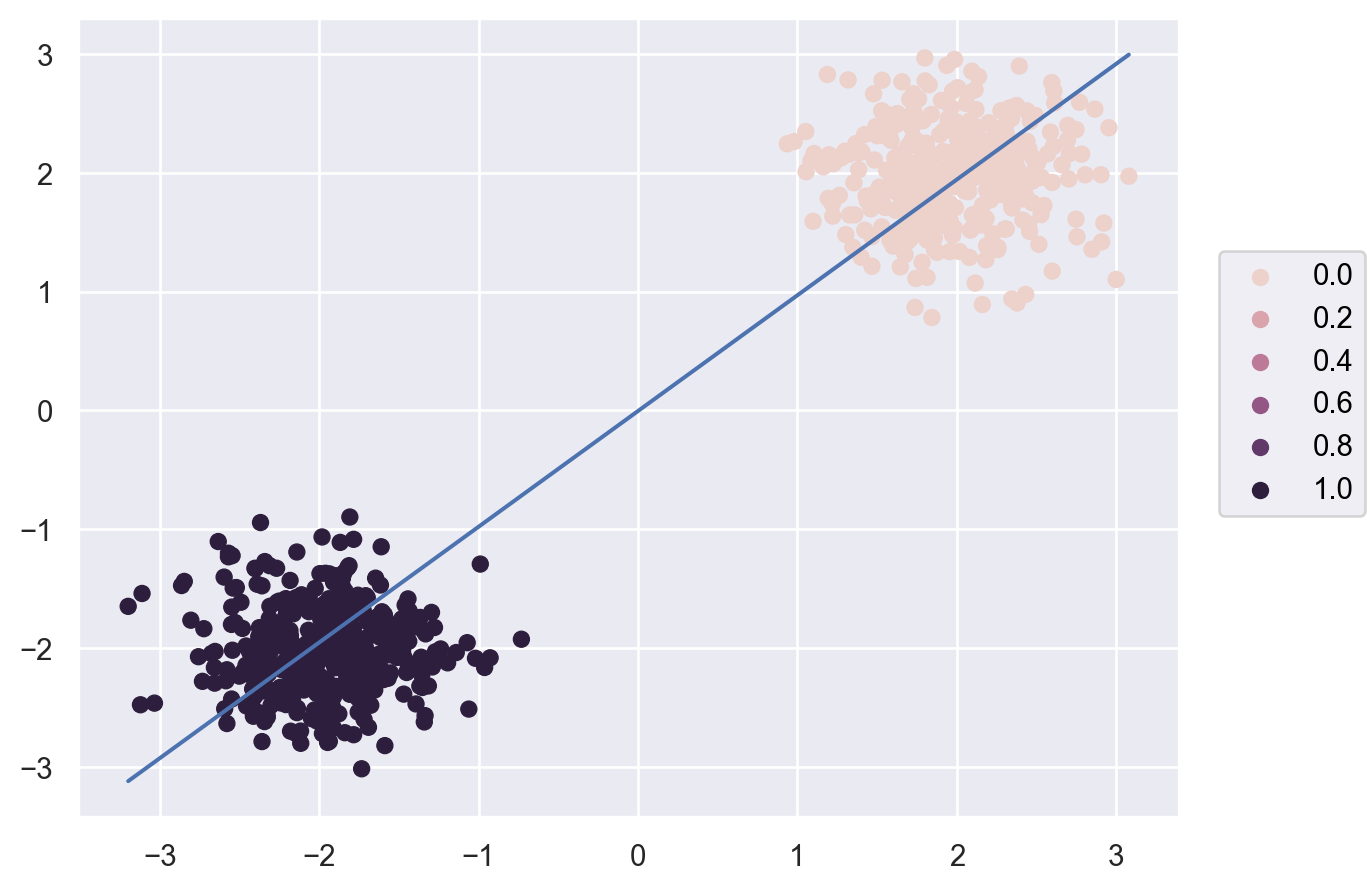

In [13]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1))
)

En este ejemplo, podríamos decir que hay correlación entre la variable $x$ y la variable $y$?

Calculemos el R^2...

In [14]:
modelo = linear_model.LinearRegression()    # Inicializamos un modelo de Regresion Lineal
modelo.fit(pd.DataFrame(x), y)   # Realiza

print("Coeficientes:", modelo.coef_)

# Medidas de bondad

y_pred = modelo.predict(pd.DataFrame(X[:,0]))

# Calculando el R^2
r2 = r2_score(X[:,1], y_pred)
print('R^2: ', r2)

Coeficientes: [0.97356812]
R^2:  0.9255602605070439


Los datos parecen altamente correlacionados. Pero si separamos por grupo...

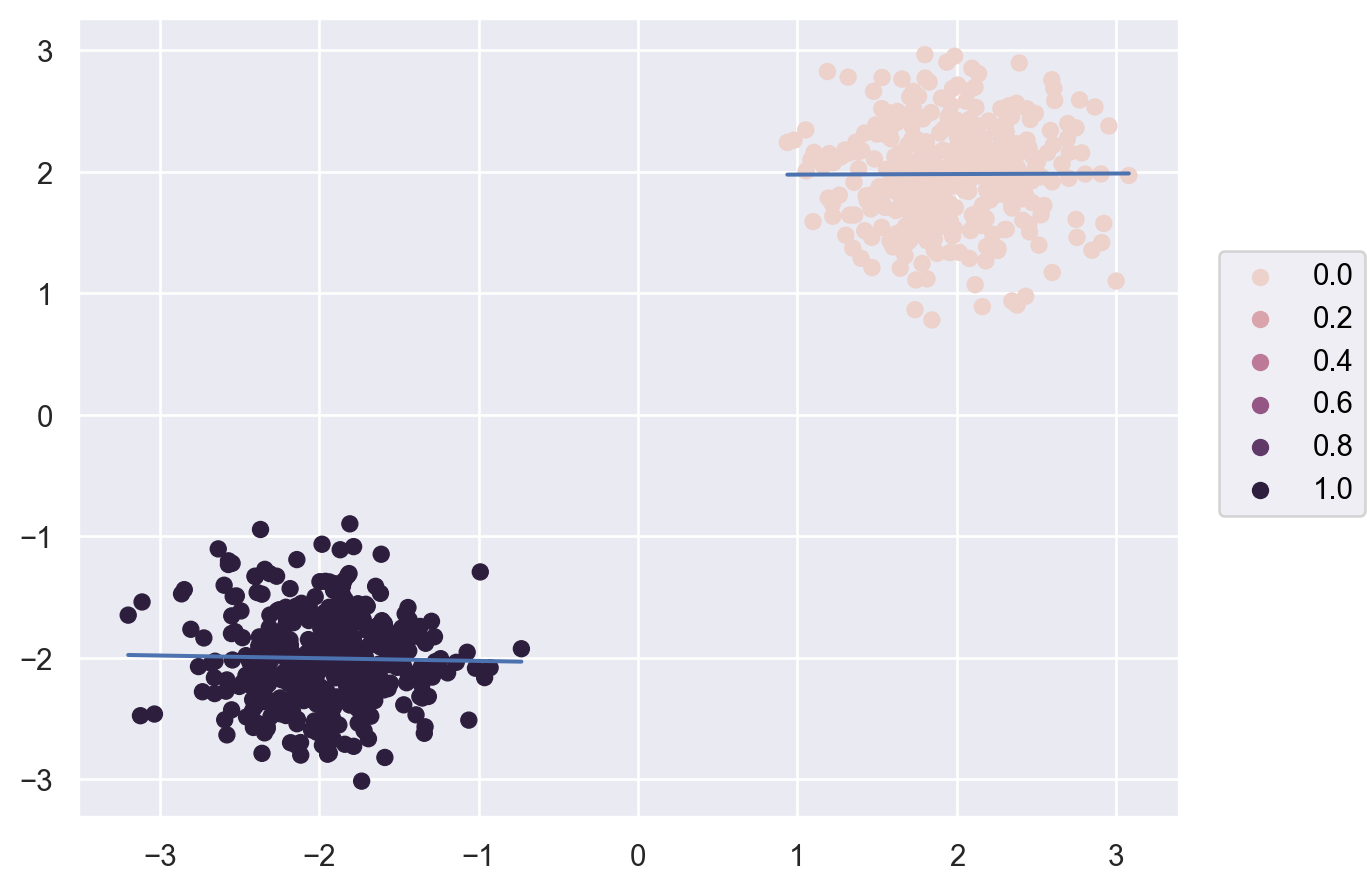

In [15]:
(
    so.Plot(x = x, y = y)
    .add(so.Dot(), color = labels_true)
    .add(so.Line(), so.PolyFit(1), group = labels_true)
)

Vemos en el gráfico que la pendiente ahora pasa a ser casi 0.

¿Cómo podemos construir nosotros estos modelos y calcular los coeficientes y el R^2?

Recordemos las operaciones que nos permite hacer Formulaic.

| Operador | Ejemplo          | Función                                                                                           |
|:---------|:-----------------|:---------------------------------------------------------------------------------------------------|
| ~        | y ~ x            | Separa la variable (y) respuesta a la izquierda, de el/los predictor/es a la derecha (x).       |
| +        | y ~ x + z        | Adiciona (suma) términos al modelo.                                                              |
| :        | y ~ x : z        | Interacción entre términos. y es lineal en x ⋅ z.                                                |
| *        | y ~ x * z        | Combina adición e interacción entre términos. y ~ x * z es equivalente a y ~ x + z + x : z       |

In [24]:
y, X = Formula("bill_depth_mm ~ bill_length_mm + species").get_model_matrix(penguins)
display(X)

,Intercept,bill_length_mm,species[T.Chinstrap],species[T.Gentoo]
0,1.0,39.1,0,0
1,1.0,39.5,0,0
2,1.0,40.3,0,0
4,1.0,36.7,0,0
5,1.0,39.3,0,0
...,...,...,...,...
338,1.0,47.2,0,1
340,1.0,46.8,0,1
341,1.0,50.4,0,1
342,1.0,45.2,0,1


In [17]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[10.56526162  0.20044313 -1.93307791 -5.10331533]]


**Pregunta:** ¿Cuáles coeficientes nos indican las pendientes de las rectas?

In [18]:
# Calculamos el R^2
y_pred = modelo.predict(X)

# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

R^2:  0.7672810738905526


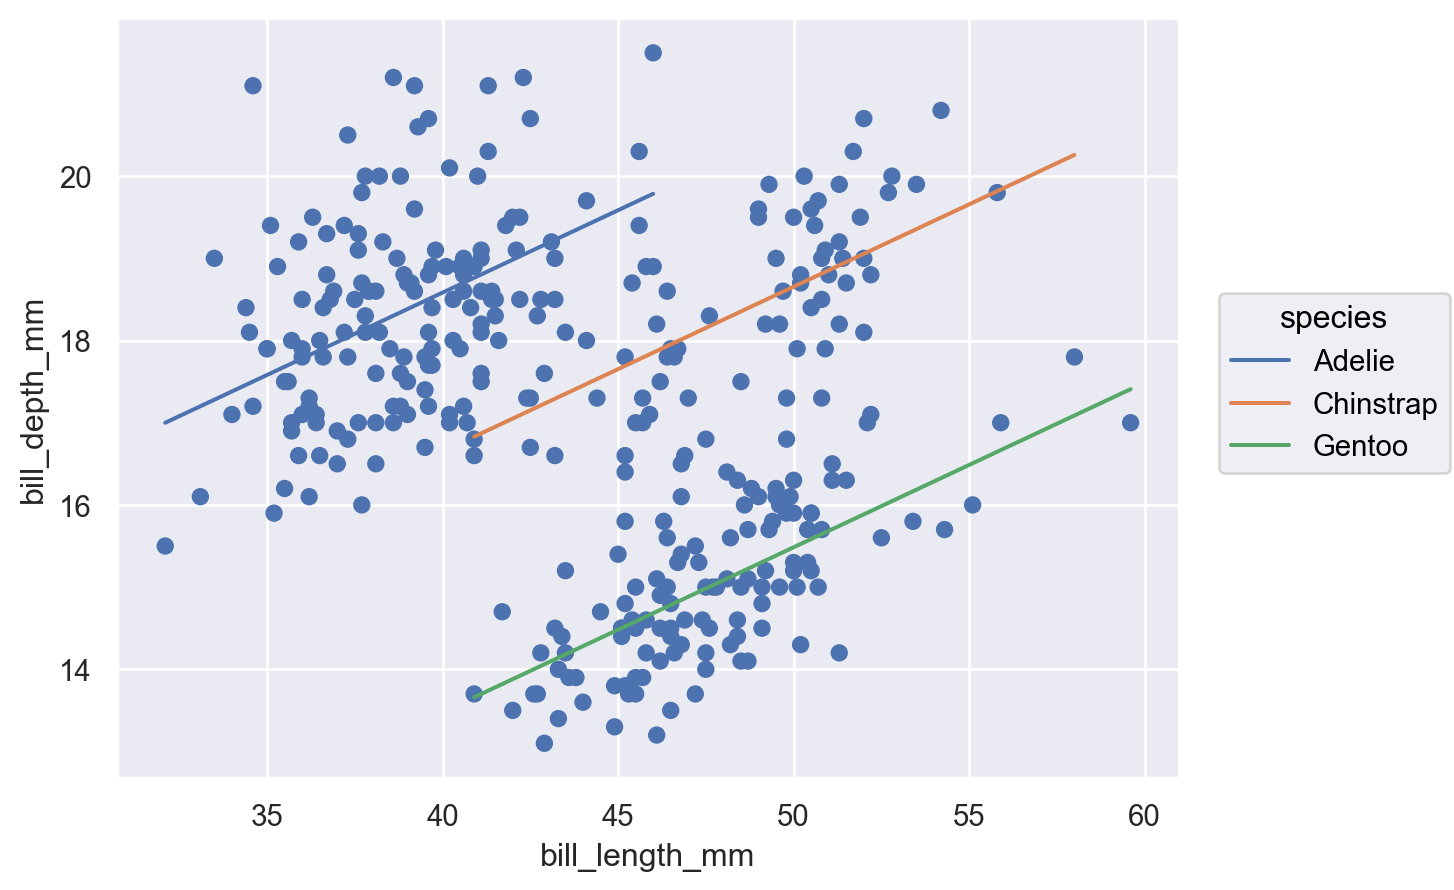

In [19]:
# Los últimos tres números son las pendientes de las rectas.
# Cómo podemos graficar este modelo?

y_pred = modelo.predict(X).flatten()

(
    so.Plot(data = penguins, x = "bill_length_mm")
    .add(so.Line(), y = y_pred, color = "species")  # Otro milagro!! No le tenía ninguna fe a esto :)
    .add(so.Dot(), y = "bill_depth_mm")
)

In [20]:
y, X = Formula("bill_depth_mm ~ (1 + bill_length_mm) : species - 1").get_model_matrix(penguins)
display(X)

,species[T.Adelie],species[T.Chinstrap],species[T.Gentoo],bill_length_mm:species[T.Adelie],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
0,1,0,0,39.1,0.0,0.0
1,1,0,0,39.5,0.0,0.0
2,1,0,0,40.3,0.0,0.0
4,1,0,0,36.7,0.0,0.0
5,1,0,0,39.3,0.0,0.0
...,...,...,...,...,...,...
338,0,0,1,0.0,0.0,47.2
340,0,0,1,0.0,0.0,46.8
341,0,0,1,0.0,0.0,50.4
342,0,0,1,0.0,0.0,45.2


In [21]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)
y_pred = modelo.predict(X).flatten()

Coeficientes: [[11.48770713  7.56914012  5.12095595  0.17668344  0.22221172  0.2076116 ]]


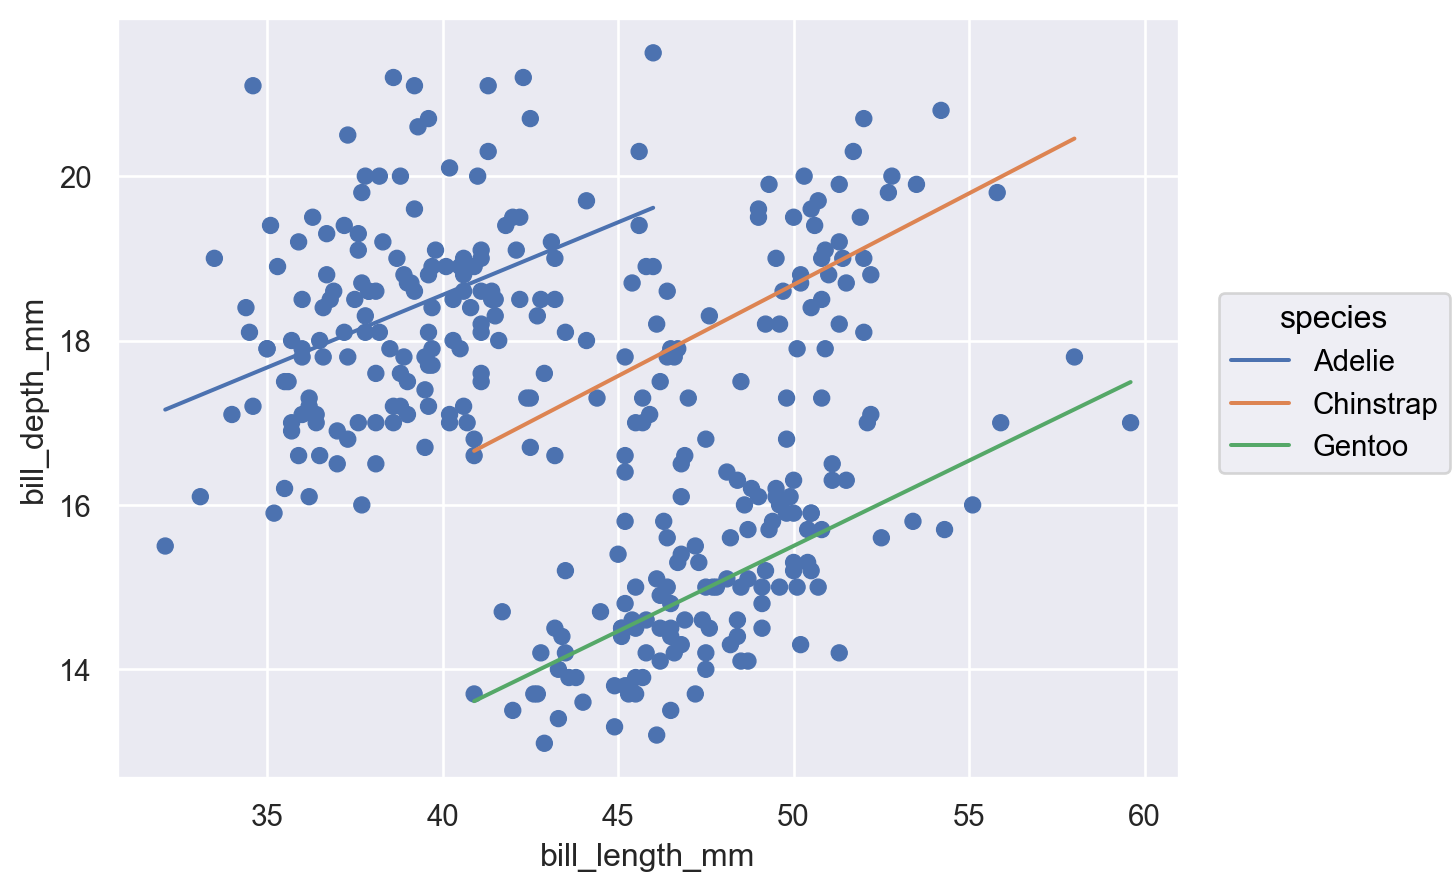

In [22]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Line(), y = y_pred, color = "species")  # Otro milagro!! No le tenía ninguna fe a esto :)
    .add(so.Dot())
)

**Ejercicio.** Realizar ahora un modelo donde todas las rectas tengan la misma pendiente y solo cambie el intercept según la especie.

# Validación cruzada
Queremos estimar los costos de salud que tendrá un cliente de una prepaga en función de algunas variables de la persona.

In [ ]:
df_salud = pd.read_csv('insurance.csv')
df_salud

La variable respuesta es `charges` y el resto son variables explicativas.

**Pregunta:** ¿Cuáles son variables numércias? ¿Cuáles son categóricas? Las variables categóricas son: ¿binarias, nominales, ordinales?

In [ ]:
df_salud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**Pregunta:** ¿Cuántas categorías tiene la variable `region`?

In [ ]:
# Otro comando útil para analizar las variables numéricas
df_salud.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Por ejemplo, en la variable `charges` vemos que el promedio es 13270, y el máximo es 63770. Esto podría indica la presencia de outliers, que dificultan el modelo. ¿Cómo podemos visualizar los outliers?

Por el momento dejamos los outliers, veremos más adelante pasos para limpieza de datos.

## Nivel 1: entrenamos y testeamos el modelo usando todos los datos

In [ ]:
y, X = (
    Formula('charges ~ age + sex + bmi + children + smoker + region')
    .get_model_matrix(df_salud)
)
X.head()

,Intercept,age,sex[T.male],bmi,children,smoker[T.yes],region[T.northwest],region[T.southeast],region[T.southwest]
0,1.0,19,0,27.900,0,1,0,0,1
1,1.0,18,1,33.770,1,0,0,1,0
2,1.0,28,1,33.000,3,0,0,1,0
3,1.0,33,1,22.705,0,0,1,0,0
4,1.0,32,1,28.880,0,0,1,0,0


In [ ]:
# Podemos ver la correlación entre las distintas variables (corresponde al R de un modelo lineal y=ax+b)
pd.concat([X,y], axis = 1).corr()

,Intercept,age,sex[T.male],bmi,children,smoker[T.yes],region[T.northwest],region[T.southeast],region[T.southwest],charges
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,1.000000,-0.020856,0.109272,0.042469,-0.025019,-0.000407,-0.011642,0.010016,0.299008
sex[T.male],NaN,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.011156,0.017117,-0.004184,0.057292
bmi,NaN,0.109272,0.046371,1.000000,0.012759,0.003750,-0.135996,0.270025,-0.006205,0.198341
children,NaN,0.042469,0.017163,0.012759,1.000000,0.007673,0.024806,-0.023066,0.021914,0.067998
smoker[T.yes],NaN,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.036945,0.068498,-0.036945,0.787251
region[T.northwest],NaN,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,1.000000,-0.346265,-0.320829,-0.039905
region[T.southeast],NaN,-0.011642,0.017117,0.270025,-0.023066,0.068498,-0.346265,1.000000,-0.346265,0.073982
region[T.southwest],NaN,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.320829,-0.346265,1.000000,-0.043210
charges,NaN,0.299008,0.057292,0.198341,0.067998,0.787251,-0.039905,0.073982,-0.043210,1.000000


In [ ]:
# Ajustamos el modelo
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[-11938.53857617    256.85635254   -131.3143594     339.19345361
     475.50054515  23848.53454191   -352.96389942  -1035.02204939
    -960.0509913 ]]


In [ ]:
# Predicciones
y_pred = modelo.predict(X)

# Bondad del ajuste
r2 = r2_score(y, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.7509130345985207
Raiz cuadarada del ECM:  6041.6796511744515


## Nivel 2: separamos en entrenamiento y testeo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Ajustamos el modelo
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X_train, y_train)   # Realiza

# Predicciones
y_pred = modelo.predict(X_test)

# Bondad del ajuste
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.7835929767120721
Raiz cuadarada del ECM:  5796.284659276276


**Pregunta:** Con la semilla aleatoria 42 bajó el ECM. Si cambiamos la semilla por ejemplo a 4?

## Nivel 3: separamos en entrenamiento, validación y testeo
#### Paso 1: separamos en entrenamiento y testeo el dataframe original

In [ ]:
df_train, df_test = train_test_split(df_salud, test_size=0.2, random_state=42)
df_train.shape

(1070, 7)

Podemos también primero aplicar transformar las variables y después separar en entrenamiento y testeo, pero es preferible separar al principio el conjunto de testeo, para evitar usar en el entrenamiento datos del conjunto de testeo.

#### Paso 2A: definimos un primer modelo y separamos el dataset df_train en entrenamiento y validación para entrenar el modelo.

In [ ]:
formula1 = 'charges ~ age + sex + bmi + children + smoker + region'
y1, X1 = (
    Formula(formula1)
    .get_model_matrix(df_train)
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=42)
X_train.shape

(856, 9)

In [ ]:
modelo1 = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo1.fit(X_train, y_train)   # Realiza

# Predicciones
y_pred = modelo1.predict(X_val)

# Bondad del ajuste
r2 = r2_score(y_val, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y_val, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.7268029806501226
Raiz cuadarada del ECM:  6602.039502172556


#### Paso 2B: definimos otro modelo y repetimos el paso 2A

In [ ]:
formula2 = 'charges ~ age + bmi + smoker + children'
y2, X2 = (
    Formula(formula2)
    .get_model_matrix(df_train)
)
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train.shape

(856, 5)

In [ ]:
modelo2 = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo2.fit(X_train, y_train)   # Realiza

# Predicciones
y_pred = modelo2.predict(X_val)

# Bondad del ajuste
r2 = r2_score(y_val, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y_val, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.7263709097118607
Raiz cuadarada del ECM:  6607.258121408381


#### Paso 3: de los modelos probados, nos quedamos con el de menor RECM. 
Analizamos como funciona el modelo en el conjunto de validación.

Para esto, entrenamos el modelo ganador utilizando TODOS los datos de entrenamiento (el modelo es la fórmula, no los coeficientes).

**Recordar:** mientras mas datos usamos para entrenar, mejor!

In [ ]:
# Ajustamos nuestro modelo ganador en TODO el conjunto de entrenamiento. 
modelo1.fit(X1, y1)

# Realizamos las mismas transformaciones en el conjunto de testeo
y_test, X_test = (
    Formula(formula1)
    .get_model_matrix(df_test)
)

# Predicciones
y_pred = modelo1.predict(X_test)

# Bondad del ajuste
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

R^2:  0.7835929767120721
Raiz cuadarada del ECM:  5796.284659276276


## Nivel 4: separamos en entrenamiento y testeo, y hacemos validación cruzada en el conjunto de entrenamiento.
### Paso 1: separamos en entrenamiento y testeo el dataframe original

In [ ]:
# La misma separación del Nivel 3
df_train, df_test = train_test_split(df_salud, test_size=0.2, random_state=42)
df_train.shape

(1070, 7)

#### Paso 2A: definimos un primer modelo y lo ajustamos por validación cruzada en el conjunto de entrenamiento.

In [ ]:
formula1 = 'charges ~ age + sex + bmi + children + smoker + region'
y1, X1 = (
    Formula(formula1)
    .get_model_matrix(df_train)
)

In [ ]:
# Definimos los subconjuntos para la validación cruzada.
# Utilizamos KFold de sklearn
cv = KFold(n_splits=5, random_state=42, shuffle=True)

## Generadores e iteradores perezosos en Python
Nos detenemos un momento para entender qué nos devuelve KFold

In [ ]:
# Esto solo nos muestra las opciones que utilizamos
cv

KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
# La forma de utilizado es a través del método split
pliegos = cv.split(X1)
pliegos

<generator object _BaseKFold.split at 0x7c9ee71bdd90>

`split` nos devuelve un "generador", esto es un **iterador perezoso** (lazy iterator).

Los iteradores perezosos son objetos que se pueden recorrer como una lista. 

Sin embargo, a diferencia de las listas, los iteradores perezosos no almacenan su contenido en la memoria, lo van generando a medida que lo necesitamos.


In [ ]:
# Podemos acceder a los elementos a través de la función next
next(pliegos)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
          12,   13,   14,   15,   18,   20,   21,   22,   23,   24,   25,
          27,   28,   29,   30,   31,   32,   33,   34,   35,   39,   40,
          41,   42,   43,   44,   46,   47,   49,   51,   52,   54,   55,
          56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
          67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
          78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
          89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
         100,  101,  102,  104,  105,  106,  107,  108,  109,  110,  113,
         114,  116,  117,  118,  120,  121,  124,  125,  126,  128,  130,
         131,  132,  133,  134,  135,  136,  137,  138,  139,  140,  141,
         144,  145,  148,  149,  153,  155,  156,  158,  159,  161,  163,
         164,  165,  166,  167,  168,  169,  170,  172,  173,  174,  176,
         177,  178,  179,  181,  182, 

In [ ]:
# Pero lo mas común es utilizarlos en un ciclo:
pliegos = cv.split(X1)
for train_index, test_index in pliegos:
    print(test_index[0:10])

[ 2  3 10 12 23 30 31 39 49 51]
[ 0  5  7  9 25 29 33 43 44 55]
[ 6 11 15 18 22 24 28 41 42 46]
[ 8 16 17 19 26 36 37 38 45 48]
[ 1  4 13 14 20 21 27 32 34 35]


In [ ]:
# Ahora no quedo nada, ya generó todo lo que tenía para generar
next(pliegos)

StopIteration: 

In [ ]:
# Acá tampoco hay nada...
for train_index, test_index in pliegos:
    print(test_index[0:10])

#### Volvemos al Paso 2A

In [ ]:
# Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
for train_index, val_index in cv.split(X1):
    X_train, X_val, y_train, y_val = X1.iloc[train_index], X1.iloc[val_index], y1.iloc[train_index], y1.iloc[val_index]
    
    # Acá tenemos que hacer el ajuste y la predicción para cada pliego

Agregamos el codigo para ajuste y predicción

In [ ]:
modelo1 = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
rmse1 = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0

# Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
for train_index, test_index in cv.split(X1):
    X_train, X_val, y_train, y_val = X1.iloc[train_index], X1.iloc[val_index], y1.iloc[train_index], y1.iloc[val_index]
    modelo1.fit(X_train, y_train)
    
    y_pred = modelo1.predict(X_val)
    rmse1[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
    ind = ind + 1

In [ ]:
print(rmse1)

In [ ]:
print(rmse1.mean())  # Este es el valor que queremos minimizar

#### Paso 2B: definimos otro modelo y repetimos el paso 2A

In [ ]:
formula2 = 'charges ~ age + bmi + children + region + smoker'
y2, X2 = (
    Formula(formula2)
    .get_model_matrix(df_train)
)

cv = KFold(n_splits=5, random_state=42, shuffle=True)  # No es necesario definirlo nuevamente, solo para recordar que era.

modelo2 = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
rmse2 = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0

# Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
for train_index, test_index in cv.split(X2):
    X_train, X_val, y_train, y_val = X2.iloc[train_index], X2.iloc[val_index], y2.iloc[train_index], y2.iloc[val_index]
    modelo2.fit(X_train, y_train)
    
    y_pred = modelo2.predict(X_val)
    rmse2[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
    ind = ind + 1

In [ ]:
print(rmse2)
print(rmse2.mean())  # Este es el valor que queremos minimizar

#### Paso 3: de los modelos probados, nos quedamos con el de menor RECM. 
Analizamos como funciona el modelo en el conjunto de validación.

Copiamos el mismo código del paso 3 del nivel 3.

In [ ]:
# Ajustamos nuestro modelo ganador en TODO el conjunto de entrenamiento. 
modelo2.fit(X2, y2)

# Realizamos las mismas transformaciones en el conjunto de testeo
y_test, X_test = (
    Formula(formula2)
    .get_model_matrix(df_test)
)

# Predicciones
y_pred = modelo2.predict(X_test)

# Bondad del ajuste
r2 = r2_score(y_test, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

## Ejercicio

Repetir los ejercicios de la prática 5 utilizando validación cruzada para seleccionar el mejor modelo.
